In [1]:
# Other imports
import numpy as np
import torch
import sys
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import Counter
import pdb
sys.path.append('..')

# DeepCASE Imports
from deepcase.preprocessing   import Preprocessor
from deepcase.context_builder import ContextBuilder
from deepcase.interpreter     import Interpreter

import matplotlib.pyplot as plt



DEBUG = True
context_length = 10

if DEBUG:
    config = {
    'learning_rates': [0.001],
    'eps':            [0.2],        # Epsilon value to use for DBSCAN clustering, in paper this was 0.1 
    'threshold':      [0.2]
    }
    epochs = 5
else:
    config = {
        'learning_rates': [0.001,0.0001,0.00001],
        'eps':            [0.3,0.2,0.15,0.1],        # Epsilon value to use for DBSCAN clustering, in paper this was 0.1 
        'threshold':      [0.2,0.15,0.1,0.05,0.01]         # Confidence threshold used for determining if attention from the ContextBuilder can be used, in paper this was 0.2
        }

########################################################################
#                             Loading data                             #
########################################################################

# define dictionary of parameters


# Create preprocessor
preprocessor = Preprocessor(
    length  = context_length,    # 10 events in context
    timeout = 86400, # Ignore events older than 1 day (60*60*24 = 86400 seconds)
)

# Load data from file
fox_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/fox_alerts.txt'
harrison_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/harrison_alerts.txt'
russellmitchell_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/russellmitchell_alerts.txt'
santos_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/santos_alerts.txt'
shaw_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/shaw_alerts.txt'
wardbeck_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wardbeck_alerts.txt'
wheeler_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wheeler_alerts.txt'
wilson_alerts = '../../../datasets/ait_alerts_csv/alerts_csv/wilson_alerts.txt'

#context, events, mapping, mapping_label, labels  = preprocessor.text(fox_alerts)
context, events,  mapping, mapping_label, labels = preprocessor.text(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#context, events,  mapping, mapping_label, labels = preprocessor.text(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#pdb.set_trace()
events = torch.tensor(np.array(events))
#labels = torch.tensor(np.array(labels))
labels = torch.tensor(np.array(labels))

# In case no labels are provided, set labels to -1
# IMPORTANT: If no labels are provided, make sure to manually set the labels
# before calling the interpreter.score_clusters method. Otherwise, this will
# raise an exception, because scores == NO_SCORE cannot be computed.
if labels is None:
    labels = np.full(events.shape[0], -1, dtype=int)

# Cast to cuda if available
if torch.cuda.is_available():
    events  = events.to('cuda')
    context = context.to('cuda')


the total number of samples: 380588
the number of false positive: 357548
the number of analomal samples: 23040 


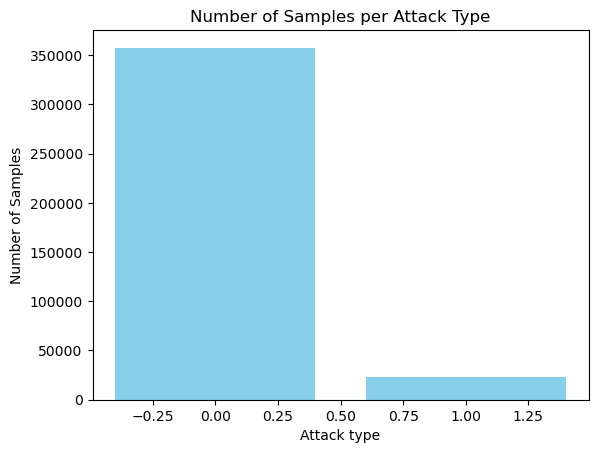

In [2]:
print(f'the total number of samples: {len(labels)}')
print(f'the number of false positive: {sum(labels==0)}')
print(f'the number of analomal samples: {sum(labels==1)} ')

counter_bin = Counter(np.array(labels))
labels_bin = list(counter_bin.keys())
values_bin = list(counter_bin.values())

plt.figure()
plt.bar(labels_bin,values_bin,color='skyblue')
plt.xlabel("Attack type")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Attack Type")
plt.show()

In [3]:
########################################################################
#                            Splitting data                            #
########################################################################

# Split into train and test sets (20:80) by time - assuming events are ordered chronologically
# events_test  = events [:events.shape[0]//5 ]
# events_train   = events [ events.shape[0]//5:]

# context_test = context[:events.shape[0]//5 ]
# context_train  = context[ events.shape[0]//5:]

# #labels_train  = labels [:events.shape[0]//5 ]
# #labels_test   = labels [ events.shape[0]//5:]

# labels_test_binary  = labels[:events.shape[0]//5 ]
# labels_train_binary   = labels[ events.shape[0]//5:]

context_train, context_test, labels_train_binary,labels_test_binary = train_test_split(context,labels,test_size=0.4,random_state=35)
events_train , events_test ,                                        = train_test_split(events, test_size=0.4,random_state=35)

In [4]:
########################################################################
#                         Using ContextBuilder                         #
########################################################################

vocab_size = len(np.unique(list(mapping)))
# embed_size = 128
# num_heads = 4
# hidden_size = 256
# num_layers = 4
# num_classes = len(np.unique(labels.to('cpu')))
# max_seq_length = 10
# Create ContextBuilder
context_builder = ContextBuilder(
    input_size    = vocab_size,   # Number of input features to expect
    output_size   = vocab_size,   # Same as input size
    hidden_size   = 128,   # Number of nodes in hidden layer, in paper we set this to 128
    max_length    = context_length,    # Length of the context, should be same as context in Preprocessor
)

# Cast to cuda if available
if torch.cuda.is_available():
    context_builder = context_builder.to('cuda')

# Train the ContextBuilder
context_builder.fit(
    X             = context_train,               # Context to train with
    y             = events_train.reshape(-1, 1), # Events to train with, note that these should be of shape=(n_events, 1)
    labels        = labels_train_binary,
    epochs        = 100,                          # Number of epochs to train with
    batch_size    = 128,                         # Number of samples in each training batch, in paper this was 128
    learning_rate = 0.001,                        # Learning rate to train with, in paper this was 0.01
    verbose       = True,                        # If True, prints progress
)


[Epoch 100/100 loss=0.0572]: 100%|██████████| 1784/1784 [00:11<00:00, 157.59it/s]


ContextBuilder(
  (embedding): Embedding(76, 128)
  (embedding_one_hot): EmbeddingOneHot()
  (encoder): Encoder(
    (embedding): EmbeddingOneHot()
    (recurrent): GRU(76, 128, batch_first=True)
  )
  (decoder_attention): DecoderAttention(
    (embedding): Embedding(76, 128)
    (recurrent): GRU(128, 128, batch_first=True)
    (attn): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder_event): DecoderEvent(
    (hidden): Linear(in_features=76, out_features=76, bias=True)
    (out): Linear(in_features=76, out_features=76, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [5]:
if DEBUG:
    confidence_test, _ = context_builder.predict(context_test)
    predicted_test    = torch.argmax(confidence_test.squeeze(1),dim=1).to('cpu').numpy()

    events_test_np = events_test.to('cpu').numpy()

    print(classification_report(events_test_np, predicted_test,digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        42
           1     0.2051    0.0359    0.0611       446
           2     0.0000    0.0000    0.0000        71
           3     0.0000    0.0000    0.0000         7
           4     0.0000    0.0000    0.0000        35
           5     0.0000    0.0000    0.0000         5
           6     0.0000    0.0000    0.0000         9
           7     0.0678    0.0392    0.0497       102
           8     0.0833    0.0033    0.0063       307
           9     0.2710    0.2223    0.2443       985
          10     0.0000    0.0000    0.0000         6
          11     0.0000    0.0000    0.0000        44
          12     0.0000    0.0000    0.0000        16
          13     0.0000    0.0000    0.0000        88
          14     0.0000    0.0000    0.0000         4
          15     0.0737    0.0507    0.0601       138
          16     0.0000    0.0000    0.0000        19
          17     0.5662    

/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [6]:
########################################################################
#                          Using Interpreter                           #
########################################################################

# Create Interpreter
interpreter = Interpreter(
    context_builder = context_builder, # ContextBuilder used to fit data
    features        = 100,             # Number of input features to expect, should be same as ContextBuilder
    eps             = 0.1,             # Epsilon value to use for DBSCAN clustering, in paper this was 0.1  # try 0.2 Jia
    min_samples     = 5,               # Minimum number of samples to use for DBSCAN clustering, in paper this was 5
    threshold       = 0.2,             # Confidence threshold used for determining if attention from the ContextBuilder can be used, in paper this was 0.2
)

# Cluster samples with the interpreter
clusters = interpreter.cluster(
    X          = context_train,               # Context to train with
    y          = events_train.reshape(-1, 1), # Events to train with, note that these should be of shape=(n_events, 1)
    iterations = 200,                         # Number of iterations to use for attention query, in paper this was 100
    batch_size = 1024,                        # Batch size to use for attention query, used to limit CUDA memory usage
    verbose    = True,                        # If True, prints progress
)

Clustering      : 100%|██████████| 28/28 [00:05<00:00,  5.01it/s]


In [7]:
########################################################################
#                             Manual mode                              #
########################################################################

# Compute scores for each cluster based on individual labels per sequence
scores = interpreter.score_clusters(
    scores   = labels_train_binary, # Labels used to compute score (either as loaded by Preprocessor, or put your own labels here)
    strategy = "min",        # Strategy to use for scoring (one of "max", "min", "avg")
    NO_SCORE = -1,           # Any sequence with this score will be ignored in the strategy.
                                # If assigned a cluster, the sequence will inherit the cluster score.
                                # If the sequence is not present in a cluster, it will receive a score of NO_SCORE.
)

# Assign scores to clusters in interpreter
# Note that all sequences should be given a score and each sequence in the
# same cluster should have the same score.
interpreter.score(
    scores  = scores, # Scores to assign to sequences
    verbose = True,   # If True, prints progress
)


Scoring: 100%|██████████| 28/28 [00:03<00:00,  7.43it/s]


In [8]:
########################################################################
#                        (Semi-)Automatic mode                         #
########################################################################

#Compute predicted scores
prediction = interpreter.predict(
    X          = context_test,               # Context to predict
    y          = events_test.reshape(-1, 1), # Events to predict, note that these should be of shape=(n_events, 1)
    iterations = 100,                        # Number of iterations to use for attention query, in paper this was 100
    batch_size = 1024,                       # Batch size to use for attention query, used to limit CUDA memory usage
    verbose    = True,                       # If True, prints progress
)

#Compute the accuracy


#pdb.set_trace()
mask_p_n = np.where((prediction ==0) | (prediction ==1))[0]
result_predicted = prediction[mask_p_n]
labels_test_bin = labels_test_binary[mask_p_n]
with open("output.txt", "a") as f:
    print(classification_report(labels_test_bin, result_predicted,digits=4,zero_division=0.0),file=f)
    print(f'the total number of samples: {prediction.shape[0]}', file=f)
    print(f'the number of predicted  samples: {sum(prediction ==1)+sum(prediction ==0)}',file=f)
    print(f'the percentage of predicted samples:{(sum(prediction ==1)+sum(prediction ==0))/prediction.shape[0]}',file=f)
    print(f'the number of samples that can not predicted automatically:{prediction.shape[0]-sum(prediction ==1)-sum(prediction ==0)}',file=f)
    print(f'the number of predicted positive samples: {sum(prediction ==1)}',file=f)
    print(f'the number of predicted negative samples:{sum(prediction ==0)}',file=f)
    print(50 *'*',file=f)

Predicting      : 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


In [9]:
#pdb.set_trace()
#prediction = np.round(prediction).astype(np.int64)
mask_p_n = np.where((prediction ==0) | (prediction ==1))[0]
result_predicted = prediction[mask_p_n]
labels_test_bin = labels_test_binary[mask_p_n]
print(classification_report(labels_test_bin, result_predicted,digits=4,zero_division=0.0))
print(f'the total number of samples: {prediction.shape[0]}')
print(f'the number of predicted  samples: {sum(prediction ==1)+sum(prediction ==0)}')
print(f'the percentage of predicted samples:{(sum(prediction ==1)+sum(prediction ==0))/prediction.shape[0]}')
print(f'the number of samples that can not predicted automatically:{prediction.shape[0]-sum(prediction ==1)-sum(prediction ==0)}')
print(f'the number of predicted positive samples: {sum(prediction ==1)}')
print(f'the number of predicted false positive samples:{sum(prediction ==0)}')
print(50 *'*')

              precision    recall  f1-score   support

           0     0.9813    0.9998    0.9904    133701
           1     0.9863    0.4826    0.6481      4925

    accuracy                         0.9814    138626
   macro avg     0.9838    0.7412    0.8193    138626
weighted avg     0.9815    0.9814    0.9783    138626

the total number of samples: 152236
the number of predicted  samples: 138626
the percentage of predicted samples:0.9105993326151501
the number of samples that can not predicted automatically:13610
the number of predicted positive samples: 2410
the number of predicted false positive samples:136216
**************************************************


In [10]:
np_labels_test_binary=np.array(labels_test_binary)
num_label_false_positive = sum(np_labels_test_binary == 0)
num_label_alarm          = sum(np_labels_test_binary == 1)
num_pred_false_positive  = sum(prediction            == 0)
num_pred_alarm           = sum(prediction            == 1)

print(f"num_label_false_positive:{num_label_false_positive}")
print(f"num_label_alarm :{num_label_alarm }")
print(f"num_pred_false_positive:{num_pred_false_positive}")
print(f"num_pred_alarm:{num_pred_alarm}")

num_label_false_positive:143111
num_label_alarm :9125
num_pred_false_positive:136216
num_pred_alarm:2410


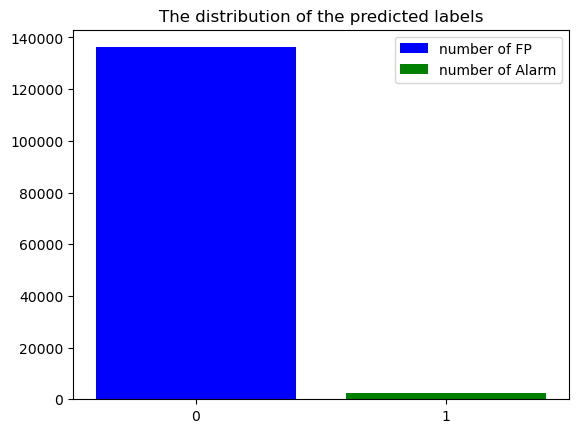

In [11]:
# The distribution of predicted labels
import matplotlib.pyplot as plt 

labels = ['0','1']
values = [num_pred_false_positive, num_pred_alarm]
#plt.figure(figsize=(8,6))
plt.figure()
bars = plt.bar(labels, values,color=['blue','green'])
plt.legend(bars,['number of FP', 'number of Alarm'])
plt.title("The distribution of the predicted labels")
plt.show()

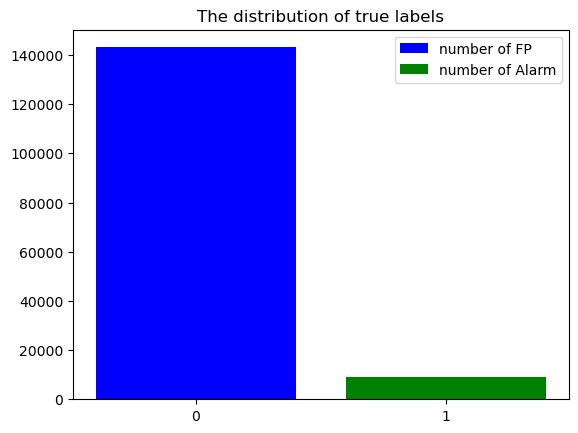

In [12]:
# The distribution of true labels
import matplotlib.pyplot as plt 

labels = ['0','1']
values = [num_label_false_positive, num_label_alarm]
#plt.figure(figsize=(8,6))
plt.figure()
bars = plt.bar(labels, values,color=['blue','green'])
plt.legend(bars,['number of FP', 'number of Alarm'])
plt.title("The distribution of true labels")
plt.show()

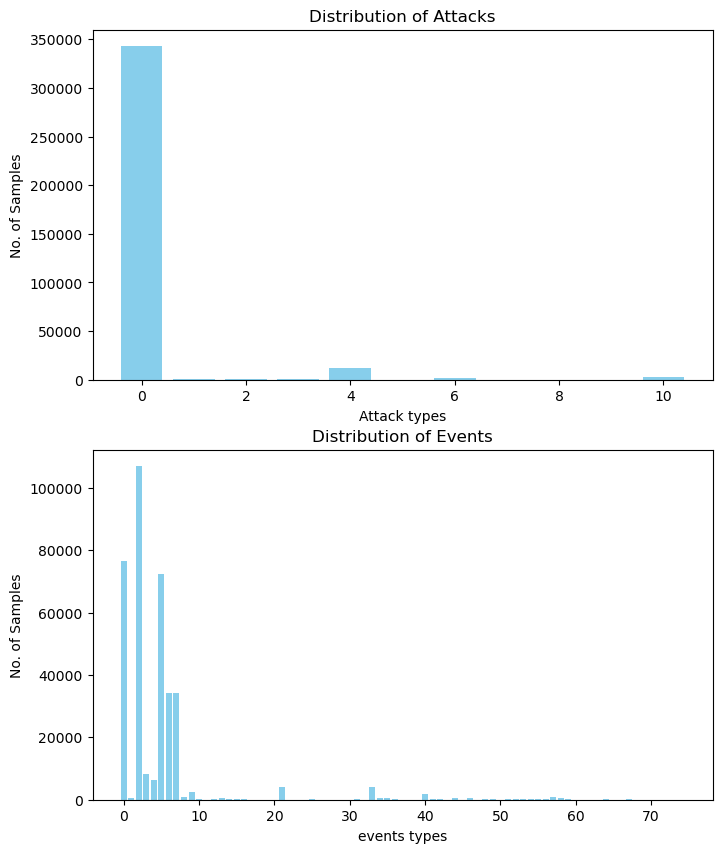

In [13]:
# Analysis the dataset. The distribution of attack types and events
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

data = Preprocessor.read_csv_files(fox_alerts,harrison_alerts,russellmitchell_alerts,santos_alerts,shaw_alerts,wardbeck_alerts,wheeler_alerts,wilson_alerts)
#data = pd.read_csv(fox_alerts)

data_labels = data['time_label']
counter_labels = Counter(data_labels)
labels_attack = list(counter_labels.keys())
values_attack = list(counter_labels.values())

mapping_attack = {i:a for i, a in enumerate(labels_attack)}
labels_attack_id = mapping_attack.keys()

events =data['short']
counter_events = Counter(events)
labels_events = list(counter_events.keys())
values_events = list(counter_events.values())

mapping_events= {i:l for i,l in enumerate(labels_events)}
labels_events_id = mapping_events.keys()
info_text = '\n'.join([f"{key}:{value}" for key, value in mapping_events.items()])

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,10))

ax1.bar(labels_attack_id,values_attack,color='skyblue')
ax1.set_xlabel('Attack types')
ax1.set_ylabel('No. of Samples')
ax1.set_title('Distribution of Attacks')
# ax1.text(0.95, 0.95, info_text, 
#          horizontalalignment='right', 
#          verticalalignment='top', 
#          transform=plt.gca().transAxes,
#          bbox=dict(facecolor='white', alpha=0.5))

ax2.bar(labels_events_id,values_events,color='skyblue')
ax2.set_xlabel('events types')
ax2.set_ylabel('No. of Samples')
ax2.set_title('Distribution of Events')

#plt.tight_layout()
plt.show()



# plt.figure(figsize=(10,6))
# plt.bar(labels_attack,values_attack,color='skyblue')
# plt.xlabel("Attack type")
# plt.ylabel("Number of Samples")
# plt.title("Number of Samples per Attack Type")
# plt.show()
